# ELO Merchant Cathegory Recomendation - Analysis for Kaggle

## Description

This challenge is about restaurant recommendations based on your personal preferences. Featuring credit card preferences.


## Authors

* Erika Muñoz: [emunozto](https://www.github.com/emunozto)
* Jose Nandez: [jnandez](https://www.github.com/jnandez)

In [17]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None #avoid warnings of versions of pandas
pd.set_option('display.max_columns',None) #display all the columns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=24 # images runs with matplotlib

from IPython.core.pylabtools import figsize 
import seaborn as sns
sns.set(font_scale = 2)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from catboost import Pool,CatBoostRegressor

## Exploring Data

### Data Loading
At first, we will load all the datasets from our buckets. Our data is located in the `data` folder

In [18]:
%%time
elo_frame = pd.read_csv('../data/train.csv')
elo_test_data = pd.read_csv('../data/test.csv')
#elo_histo_trans = pd.read_csv('../data/historical_transactions.csv')

CPU times: user 307 ms, sys: 3.72 ms, total: 311 ms
Wall time: 310 ms


In [19]:
#we want to know a little bit more about the train dataset
elo_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [20]:
#let's take a pick to the first 5 records in the training set
elo_frame.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [21]:
#let's check whether we have categorical variables, indices.
elo_frame.nunique()

first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                197110
dtype: int64

In [ ]:
#let's check the historical data
elo_histo_trans.info()

In [ ]:
elo_histo_trans.head()

In [ ]:
elo_histo_trans.describe()

In [ ]:
elo_histo_trans.nunique()

### Check for missing data

In [22]:
#training set
elo_frame.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [23]:
#test set
elo_test_data.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [ ]:
elo_histo_trans.isna().sum() #missing data

In [ ]:
elo_histo_trans.isna().sum()/len(elo_histo_trans) *100

##### We get rid of any missing `merchant_id` due to those data may be rejected or incomplete transactions.

In [ ]:
elo_histo_trans = elo_histo_trans.dropna(subset=['merchant_id'])

## Data visualization

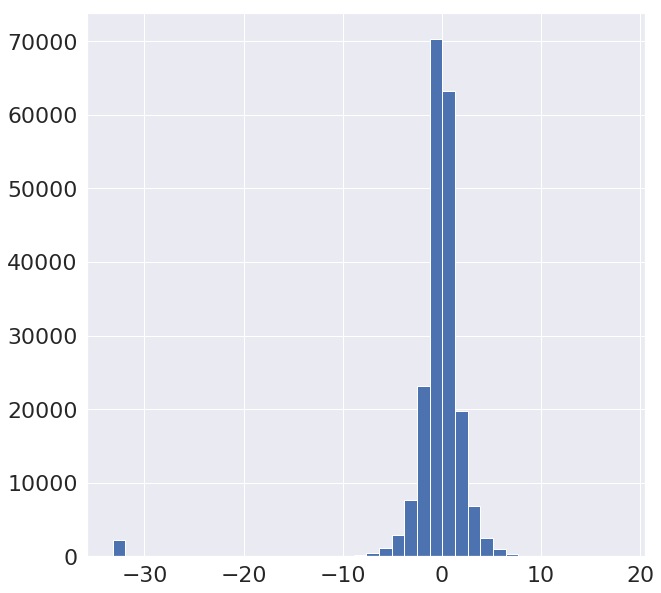

In [24]:
figsize(10,10)
plt.hist(elo_frame['target'],bins = 40);

In [25]:
elo_frame.describe()['target']

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

#### Clearly we observed extreme outliers in the target, this will be difficult to model.

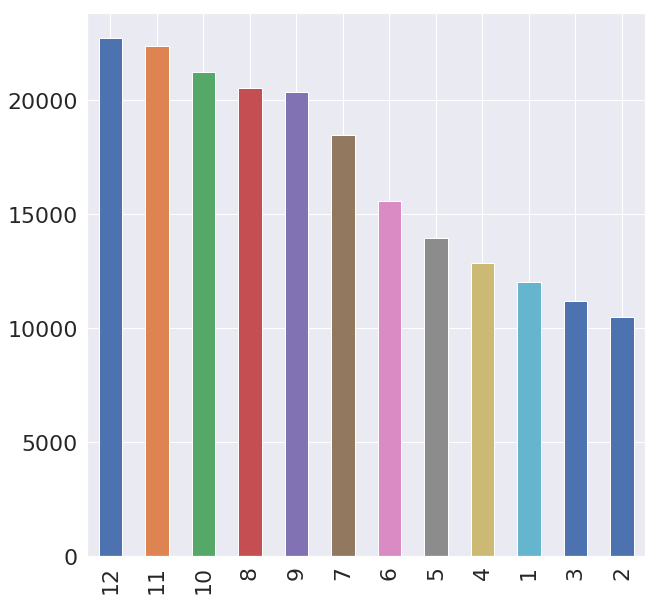

In [26]:
pd.to_datetime(elo_frame.first_active_month).dt.month.value_counts().plot(kind='bar')

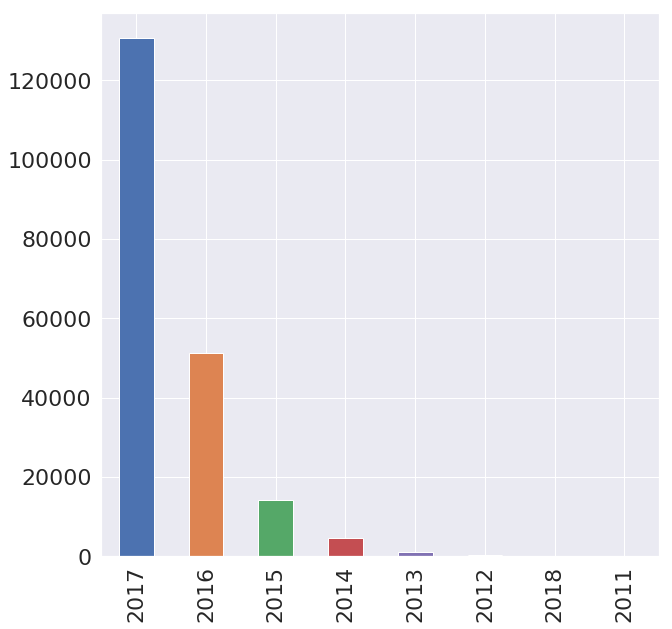

In [27]:
pd.to_datetime(elo_frame.first_active_month).dt.year.value_counts().plot(kind='bar')

## Feature Engineering
We will start by splitting the `first_active_month` into `month` and `year`, these will be treated as a categorical variables for now. We also noted previously, we have 1 record in the test set with a missing `first_active_month`. We will fill this record with the most active month from the training set. Thereafter, we want to apply a `LabelEncoder` so our cat variables are better understood by CatBoost.

In [28]:
elo_frame['month'] = pd.to_datetime(elo_frame.first_active_month).dt.month
elo_frame['year']  = pd.to_datetime(elo_frame.first_active_month).dt.year

elo_test_data          = elo_test_data.fillna(elo_frame.first_active_month.value_counts().index[0])#fill null
elo_test_data['month'] = pd.to_datetime(elo_test_data.first_active_month).dt.month
elo_test_data['year']  = pd.to_datetime(elo_test_data.first_active_month).dt.year

In [29]:
elo_frame.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,6,2017
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017


### Aggregate Historical Data

In [30]:
def f_grouping(group):
    return {'diff_merc_cat': group['merchant_category_id'].nunique()}

In [31]:
#not working for now
#elo_histo_trans.groupby('card_id').apply(f_grouping)

In [32]:
#Label encoder
var_cat = ['feature_1','feature_2','feature_3','month']
for columna in var_cat:
    le = LabelEncoder()
    le.fit(elo_frame[columna])
    elo_frame[columna] = le.transform(elo_frame[columna])   
    elo_test_data[columna] = le.transform(elo_test_data[columna])

In [33]:
elo_frame.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year
0,2017-06,C_ID_92a2005557,4,1,1,-0.820283,5,2017
1,2017-01,C_ID_3d0044924f,3,0,0,0.392913,0,2017


### Split into training and testing sets

In [34]:
X_train,X_test, y_train, y_test = train_test_split(elo_frame[['feature_1','feature_2','feature_3','month','year']],
                                                   elo_frame['target'],
                                                   test_size = 0.2,
                                                   random_state = 42
                                                  )

## Stablishing a baseline model

### Metric  

Elo Merchant competition uses the following cost function

$$RMSE = \sqrt{\frac{\sum_{i=1}^n(\hat{y}_i-y_i)^2}{n}}$$

In [35]:
def rmse(y_pred,y_real): 
    return np.sqrt(np.mean((y_pred-y_real)**2))

In [36]:
base_line = np.mean(y_train)
print('The mean guess(baseline) over train set is  \'target\' ={0:0.2}'.format(base_line))
print('The performance of my mean guess (baseline) over the test set is = {0:0.5}'.format(rmse(base_line,y_test))) 

The mean guess(baseline) over train set is  'target' =-0.39
The performance of my mean guess (baseline) over the test set is = 3.8761


## Applying a Boosting Tree Model

We will use `CatBoost` as an estimator since we have lots of cat variables in this training set.

In [37]:
list_cat_var = [] 
for column in var_cat:
    list_cat_var.append(list(X_train.columns).index(column))    

In [38]:
pool_train = Pool(X_train,y_train,cat_features=list_cat_var)
pool_test = Pool(X_test,y_test,cat_features=list_cat_var)

In [39]:
model = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.1,
                          depth = 9,
                          loss_function='RMSE',
                          rsm = 0.8,
                          od_wait = 10,
                          od_type = 'Iter')

In [40]:
model.fit(pool_train,eval_set=pool_test)

0:	learn: 3.8596348	test: 3.8919657	best: 3.8919657 (0)	total: 114ms	remaining: 1m 54s
1:	learn: 3.8559868	test: 3.8882669	best: 3.8882669 (1)	total: 195ms	remaining: 1m 37s
2:	learn: 3.8529808	test: 3.8852930	best: 3.8852930 (2)	total: 245ms	remaining: 1m 21s
3:	learn: 3.8495925	test: 3.8821792	best: 3.8821792 (3)	total: 360ms	remaining: 1m 29s
4:	learn: 3.8468043	test: 3.8794949	best: 3.8794949 (4)	total: 460ms	remaining: 1m 31s
5:	learn: 3.8448662	test: 3.8774484	best: 3.8774484 (5)	total: 495ms	remaining: 1m 22s
6:	learn: 3.8437892	test: 3.8763555	best: 3.8763555 (6)	total: 507ms	remaining: 1m 11s
7:	learn: 3.8429166	test: 3.8754677	best: 3.8754677 (7)	total: 519ms	remaining: 1m 4s
8:	learn: 3.8420280	test: 3.8744956	best: 3.8744956 (8)	total: 543ms	remaining: 59.8s
9:	learn: 3.8409374	test: 3.8733469	best: 3.8733469 (9)	total: 571ms	remaining: 56.5s
10:	learn: 3.8398883	test: 3.8723350	best: 3.8723350 (10)	total: 651ms	remaining: 58.6s
11:	learn: 3.8395123	test: 3.8719472	best: 3.

In [41]:
preds = model.predict(pool_test)

In [42]:
print('The performance of catboost over the test set is = {0:0.5}'.format(rmse(preds,y_test))) 

The performance of catboost over the test set is = 3.8672


As seen in one of the above cells, the `baseline` model performance was `3.8761` whilst the `CatBoost`'s is `3.8672` which means that Machine Learning can be applied to this particular case study.

## Feature importance
This section will help us to understand whether a feature is relevant to the model or not at all. It can also help us understand if we need to do hypertunning.

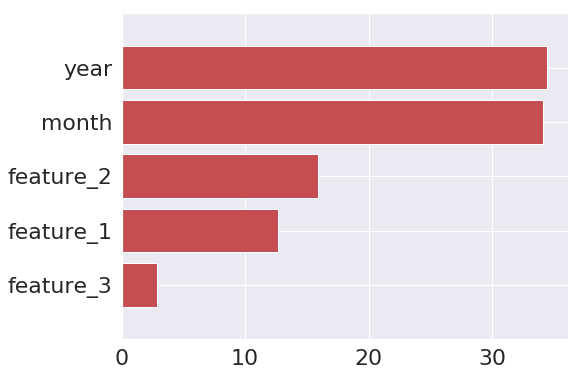

In [43]:
importances = model.feature_importances_
indices = np.argsort(importances)

figsize(8,6)
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]]);

In this exercise, we have assume that `month` is a categorical variable.

## Preparing submission for Kaggle

In [44]:
X_test    = elo_test_data[['feature_1','feature_2','feature_3','month','year']]
pool_test = Pool(X_test,cat_features = list_cat_var)

In [45]:
y_preds = model.predict(pool_test)

In [46]:
pd.DataFrame({'card_id':elo_test_data.card_id,'target':y_preds}).to_csv('ELO_submission.csv',index=None)

## Conclusion

We have used `CatBoost` to naively model Elo Marchant Kaggle Competition. We assumed that `month` is a categorical variable, and we did not make use of historical data in this version. In order to improve the model, we will need to make further feature engineering on the historical data, and also try to make statistics in the `first_active_month`, since the feature importance analysis showed that this feature is very important for predicting the `target`.